# Dependências

In [1]:
import re
import math as ma
import pprint as pp
import numpy as np
import pandas as pd
import transformer as tr
import parzen as pa
from sklearn import naive_bayes as nb
from sklearn import pipeline as pi
from sklearn import model_selection as ms
from sklearn import ensemble as en
import scipy.stats as st
import Orange as og
import matplotlib.pyplot as plt

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 2) Conhecendo os dados de "Image Segmentation"

## Leiaute
Shape view: as primeiras 9 variáveis<br>
RGB view: as 10 últimas variáveis

Observando a amostra abaixo, foi verificado que o rótulo se encontra na coluna mais à esquerda e as demais colunas são as variáveis. Conforme enunciado da questão, trata-se de um problema de classificação multiclasse, cujos rótulos são BRICKFACE, SKY, FOLIAGE, CEMENT, WINDOW, PATH, GRASS.

In [2]:
data = pd.read_csv('segmentation.test', skiprows=[0,1,2,4])
data = data.reset_index() # move rótulo do índice para uma coluna
data = data.rename(index=str, columns={'index': 'LABEL'}) # renomeia coluna do rótulo
data.head(3)

,LABEL,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
0,GRASS,110.0,189.0,9,0.0,0.0,1.000000,0.666667,1.222222,1.186342,12.925926,10.888889,9.222222,18.666668,-6.111111,-11.111111,17.222221,18.666668,0.508139,1.910864
1,GRASS,86.0,187.0,9,0.0,0.0,1.111111,0.720082,1.444444,0.750309,13.740741,11.666667,10.333334,19.222221,-6.222222,-10.222222,16.444445,19.222221,0.463329,1.941465
2,GRASS,225.0,244.0,9,0.0,0.0,3.388889,2.195113,3.000000,1.520234,12.259259,10.333334,9.333334,17.111110,-5.777778,-8.777778,14.555555,17.111110,0.480149,1.987902


Antes de passar os dados para os classificadores, é preciso confirmar que os tipos das variáveis são todos numéricos. A tabela abaixo confirma isso, pois os tipos presentes se limitam a float64 e int64. Além disso, a amostra de dados acima deixa claro que não há variáveis com dados categóricos, pois são todos ordinais. Nesse caso, as variáveis já estão em formatos compatíveis com os classificadores que serão usados mais à frente, sem a necessidade de pré-processamento.

In [3]:
data.dtypes

LABEL                    object
REGION-CENTROID-COL     float64
REGION-CENTROID-ROW     float64
REGION-PIXEL-COUNT        int64
SHORT-LINE-DENSITY-5    float64
SHORT-LINE-DENSITY-2    float64
VEDGE-MEAN              float64
VEDGE-SD                float64
HEDGE-MEAN              float64
HEDGE-SD                float64
INTENSITY-MEAN          float64
RAWRED-MEAN             float64
RAWBLUE-MEAN            float64
RAWGREEN-MEAN           float64
EXRED-MEAN              float64
EXBLUE-MEAN             float64
EXGREEN-MEAN            float64
VALUE-MEAN              float64
SATURATION-MEAN         float64
HUE-MEAN                float64
dtype: object

## Estatísticas

A tabela abaixo mostra que as variáves não estão na mesma escala e nem possuem a mesma média, mas isso não será um problema para os classificadores a serem usados mais à frente: bayesiano gaussiano e bayesiano baseado em janela de Parzen com função de kernel.

In [4]:
data.describe()

,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
count,2100.000000,2100.000000,2100.0,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2.100000e+03,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,124.940476,123.483333,9.0,0.014921,0.004550,1.890820,5.708299,2.406772,7.904224e+00,37.047654,32.806667,44.205556,34.130741,-12.722963,21.473704,-8.750741,45.162381,0.427259,-1.365147
std,72.858637,57.431428,0.0,0.041024,0.023573,2.649453,44.989359,3.469954,5.347107e+01,38.135291,34.994538,43.510119,36.303768,11.588214,19.654107,11.606996,42.900582,0.228458,1.544278
min,1.000000,11.000000,9.0,0.000000,0.000000,0.000000,0.000000,0.000000,-1.589457e-08,0.000000,0.000000,0.000000,0.000000,-49.666668,-12.444445,-33.888890,0.000000,0.000000,-3.044175
25%,62.000000,81.000000,9.0,0.000000,0.000000,0.722222,0.349603,0.833332,4.216377e-01,7.472222,7.000000,9.666667,6.222222,-18.583333,4.305556,-17.000000,11.777778,0.284934,-2.188539
50%,121.000000,122.000000,9.0,0.000000,0.000000,1.277776,0.833333,1.444444,9.897442e-01,21.666666,19.666668,27.777779,20.444445,-10.888889,19.666666,-11.000000,28.666666,0.375064,-2.052625
75%,188.250000,171.250000,9.0,0.000000,0.000000,2.222221,1.807406,2.555556,2.251852e+00,53.277778,47.333332,65.000000,46.388888,-4.222222,36.111110,-3.222222,65.000000,0.540228,-1.565745
max,254.000000,251.000000,9.0,0.333333,0.222222,29.222221,991.718400,44.722225,1.386329e+03,143.444440,137.111110,150.888890,142.555560,9.888889,82.000000,24.666666,150.888890,1.000000,2.912480


## Seleção de variáveis

A partir da tabela acima, também é possível verificar que a variável REGION-PIXEL-COUNT possui um desvio padrão igual a zero. Isso a torna irrelevante para os classificadores e pode até criar complicações na validação cruzada para definição da janela do classificador bayesiano baseado em janela de Parzen. Por isso, ela será excluída do conjunto de dados.

In [5]:
data = data.drop(columns=['REGION-PIXEL-COUNT'])

## a)  Execução do experimento.

Esta seção tem o objetido de repetir a validação cruzada estratificada "30 times ten fold" para cada classificador e para cada visão das variáveis. Para isso, vários passos de preparação e buscas em grid serão realizados para ajuste de parâmetros e a execução propriamente dita dos classificadores.<br>
Todos os passos serão descritos a seguir:

1) Definir uma semente para estado aleatório do experimento.

In [6]:
# dez primeiros dígitos de pi
seed = round(ma.pi * 10**9)
seed

3141592654

2) Separar o rótulo das variáveis.

In [7]:
# variáveis
X = data[data.columns[1:]]
# rótulo
y = data['LABEL']

3) Busca em grid para encontrar o melhor tamanho de janela para o conjunto de dados em questão. O tamanho de janela escolhido será utilizado na configuração do classificador bayesiano baseado em janela de Parzen.

In [8]:
# TODO mover para dentro do classificador de janela de Parzen
# o grid de parâmetros abaixo define os possíveis valores da janela
param_grid = {'bandwidth': [1, 2.5, 5, 7.5, 10]}
grid_search = ms.GridSearchCV(pa.ParzenWindowB(), param_grid=param_grid, cv=ms.RepeatedStratifiedKFold(n_splits=10,n_repeats=1,random_state=seed),return_train_score=False)
grid_search.fit(X, y)
bw = grid_search.best_params_['bandwidth']
bw

5

3) Busca em grid para repetir a validação cruzada extratificada para cada combinação de visão e classificador.<br>
Uma estrutura de pipeline com dois passos é criada para dar suporte à montagem das combinações. O primeiro passo do pipeline consiste na transformação que define a visão das variáveis e o segundo no classificador a ser avaliado.<br>
Nos parâmetros da busca em grid, são listadas todas as opções de visões das variáveis e classificadores a serem combinadas, seguindo a estrutura do pipeline. Conforme enunciado da questão, as visões das variáveis devem ser complete, shape e rgb e os classificadores devem ser bayesiano gaussiano e bayesiano baseado em janela de Parzen, fazendo uso da janela identificada anteriormente.<br>
Devido à diferença na estrutura do pipeline, o classificador combinado será avaliado em outra busca em grid, descrita mais à frente.

In [9]:
# o grid de parâmetros abaixo define as possíveis combinações de visões e classificadores do classificador combinado
param_grid = {'a_view': [tr.CompleteView(), tr.ShapeView(), tr.RgbView()],
              'b_clf': [nb.GaussianNB(), pa.ParzenWindowB(bandwidth=bw)]}
# todas as combinações de passos
all_steps = list(map(lambda params: list(params.items()), ms.ParameterGrid(param_grid)))
pipelines = list(map(lambda steps: ('clf'+str(all_steps.index(steps)), pi.Pipeline(steps)), all_steps))
combined = en.VotingClassifier(estimators=pipelines, voting='soft')
# os passos abaixo definem apenas a estrutura do pipeline
steps = [('a_view', tr.CompleteView()),
         ('b_clf', nb.GaussianNB())]
pipe = pi.Pipeline(steps)
# o grid de parâmetros abaixo define todas as opções de visões e classificadores simples 
# e uma opção com o classificador combinado
views = {tr.CompleteView(): 'comp',
        tr.ShapeView(): 'shape',
        tr.RgbView(): 'rgb'}
clfs = {nb.GaussianNB(): 'gnb',
        pa.ParzenWindowB(bandwidth=bw): 'pwb'}
param_grid = [{'a_view': list(views.keys()),
               'b_clf': list(clfs.keys())},
              {'b_clf': [combined]}
             ]
# a busca em grid repete o experimento para cada combinação de opções
# TODO deixar com 10 splits e 30 repetições
grid_search = ms.GridSearchCV(pipe, param_grid=param_grid, cv=ms.RepeatedStratifiedKFold(n_splits=10,n_repeats=30,random_state=seed),verbose=10,return_train_score=False)
#grid_search = ms.GridSearchCV(pipe, param_grid=param_grid, cv=ms.RepeatedStratifiedKFold(n_splits=2,n_repeats=2,random_state=seed),verbose=10,return_train_score=False)
grid_search.fit(X, y)

Fitting 300 folds for each of 7 candidates, totalling 2100 fits
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7666666666666667, total=   0.1s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7952380952380952, total=   0.1s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7904761904761904, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7952380952380952, total=   0.1s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=Gauss

[Parallel(n_jobs=4)]: Batch computation too fast (0.1218s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.3s


[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8142857142857143, total=   0.1s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8, total=   0.0s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7857142857142857, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7428571428571429, total=   0.1s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.819047619047619, total=   0.0s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8238095238095238, total=   0.1s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ...

[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.5s


[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7857142857142857, total=   0.1s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8142857142857143, total=   0.0s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7666666666666667, total=   0.1s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7761904761904762, total=   0.0s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8047619047619048, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.814285

[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    0.8s


[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.780952380952381, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8333333333333334, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8, total=   0.1s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8047619047619048, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8142857142857143, total=   0.0s
[CV] 

[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.1s


[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7857142857142857, total=   0.1s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8047619047619048, total=   0.1s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8047619047619048, total=   0.0s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7904761904761904, total=   0.1s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8, total=   0.0s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8238095238095238, total=   0.0s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(p

[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    1.6s


[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.780952380952381, total=   0.0s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8047619047619048, total=   0.0s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8095238095238095, total=   0.1s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8333333333333334, total=   0.1s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8095238095238095, total=   0.1s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8095238095238095, total=   0.1s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(p

[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.1s


[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8095238095238095, total=   0.1s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.780952380952381, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8, total=   0.1s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8142857142857143, total=   0.1s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8142857142857143, total=   0.1s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8047619047619048, total=   0.0s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), s

[Parallel(n_jobs=4)]: Done  98 tasks      | elapsed:    2.8s


[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7857142857142857, total=   0.1s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7904761904761904, total=   0.1s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7761904761904762, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8238095238095238, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7761904761904762, total=   0.1s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.780952380952381, total=   0.1s
[CV] a_view=CompleteView(), b_clf=GaussianNB(p

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    3.4s


[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7952380952380952, total=   0.1s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8095238095238095, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7952380952380952, total=   0.1s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.819047619047619, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7904761904761904, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8333333

[Parallel(n_jobs=4)]: Done 146 tasks      | elapsed:    4.0s


[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7904761904761904, total=   0.1s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8095238095238095, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7857142857142857, total=   0.0s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8047619047619048, total=   0.1s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7523809523809524, total=   0.1s
[CV

[Parallel(n_jobs=4)]: Done 172 tasks      | elapsed:    4.6s


[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7761904761904762, total=   0.0s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7952380952380952, total=   0.1s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7428571428571429, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7904761904761904, total=   0.1s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7857142857142857, total=   0.0s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7857142857142857, total=   0.0s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8047619047619048, total=   0.0s
[CV] a_view=Comp

[Parallel(n_jobs=4)]: Done 202 tasks      | elapsed:    5.4s


[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7666666666666667, total=   0.1s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8285714285714286, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.780952380952381, total=   0.1s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7761904761904762, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8428571428571429, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7952380

[Parallel(n_jobs=4)]: Done 232 tasks      | elapsed:    6.1s


[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7857142857142857, total=   0.0s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8238095238095238, total=   0.1s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8238095238095238, total=   0.1s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8047619047619048, total=   0.1s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7619047619047619, total=   0.0s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8142857142857143, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB

[Parallel(n_jobs=4)]: Done 266 tasks      | elapsed:    7.0s


[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7904761904761904, total=   0.1s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7904761904761904, total=   0.0s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.8238095238095238, total=   0.1s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.7952380952380952, total=   0.0s
[CV]  a_view=CompleteView(), b_clf=GaussianNB(priors=None), score=0.819047619047619, total=   0.0s
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV] a_view=CompleteView(), b_clf=GaussianNB(priors=None) ............
[CV]

[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:    7.8s


[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9380952380952381, total=   0.4s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9619047619047619, total=   0.4s
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9571428571428572, total=   0.4s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9666666666666667, total=   0.4s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9476190476190476, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kerne

[Parallel(n_jobs=4)]: Done 338 tasks      | elapsed:   11.7s


[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9571428571428572, total=   0.4s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9476190476190476, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9523809523809523, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9714285714285714, total=   0.4s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9523809523809523, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kerne

[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   15.2s


[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9476190476190476, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9428571428571428, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9523809523809523, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9476190476190476, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9761904761904762, total=   0.3s
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kern

[Parallel(n_jobs=4)]: Done 418 tasks      | elapsed:   18.5s


[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9333333333333333, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9761904761904762, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9333333333333333, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9619047619047619, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9666666666666667, total=   0.3s
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kern

[Parallel(n_jobs=4)]: Done 460 tasks      | elapsed:   21.9s


[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9285714285714286, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9476190476190476, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9571428571428572, total=   0.2s
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9523809523809523, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(

[Parallel(n_jobs=4)]: Done 506 tasks      | elapsed:   25.6s


[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9571428571428572, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9523809523809523, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9238095238095239, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9571428571428572, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9285714285714286, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kerne

[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:   29.4s


[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9380952380952381, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9714285714285714, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9714285714285714, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9619047619047619, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9523809523809523, total=   0.3s
[CV] a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kerne

[Parallel(n_jobs=4)]: Done 602 tasks      | elapsed:   33.0s


[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.47619047619047616, total=   0.1s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.5095238095238095, total=   0.1s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.9428571428571428, total=   0.4s
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.42857142857142855, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.4523809523809524, total=   0.1s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=CompleteView(), b_clf=ParzenWindowB(bandwidth=5, 

[Parallel(n_jobs=4)]: Done 652 tasks      | elapsed:   34.5s


[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.43333333333333335, total=   0.1s
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.43333333333333335, total=   0.1s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.4714285714285714, total=   0.1s
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.44761904761904764, total=   0.1s
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.47619047619047616, total=   0.1s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.4714285714285714, total=   0.1s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ....

[Parallel(n_jobs=4)]: Done 706 tasks      | elapsed:   36.1s


[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.4380952380952381, total=   0.1s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.44761904761904764, total=   0.1s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.48095238095238096, total=   0.1s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.5, total=   0.1s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.49047619047619045, total=   0.1s
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.43333333333333335, total=   0.1s
[CV

[Parallel(n_jobs=4)]: Done 760 tasks      | elapsed:   37.6s


[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.5238095238095238, total=   0.1s
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.44761904761904764, total=   0.1s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.48095238095238096, total=   0.1s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.45714285714285713, total=   0.1s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.49047619047619045, total=   0.1s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.4857142857142857, to

[Parallel(n_jobs=4)]: Done 818 tasks      | elapsed:   39.3s


[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.49047619047619045, total=   0.1s
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.46190476190476193, total=   0.1s
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.48095238095238096, total=   0.1s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.48095238095238096, total=   0.1s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.5, total=   0.1s
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.4666666666666667, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV

[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   41.0s


[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.47619047619047616, total=   0.1s
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.47619047619047616, total=   0.0s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.48095238095238096, total=   0.1s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.4095238095238095, total=   0.1s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.4857142857142857, total=   0.1s
[CV] a_view=ShapeView(), b_clf=GaussianNB(priors=None) ...............
[CV]  a_view=ShapeView(), b_clf=GaussianNB(priors=None), score=0.5142857142857142, tot

[Parallel(n_jobs=4)]: Done 938 tasks      | elapsed:   45.7s


[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.5904761904761905, total=   0.3s
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.6, total=   0.3s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.5571428571428572, total=   0.3s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.5904761904761905, total=   0.3s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.6047619047619047, total=   0.3s
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.5761904761904761, tot

[Parallel(n_jobs=4)]: Done 1000 tasks      | elapsed:   51.3s


[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.5761904761904761, total=   0.4s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.6095238095238096, total=   0.3s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.6142857142857143, total=   0.3s
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.5904761904761905, total=   0.3s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.5666666666666667, total=   0.3s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=Sh

[Parallel(n_jobs=4)]: Done 1066 tasks      | elapsed:   57.0s


[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.5666666666666667, total=   0.3s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.5857142857142857, total=   0.3s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.5666666666666667, total=   0.3s
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.5619047619047619, total=   0.3s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.6142857142857143, total=   0.3s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=Sh

[Parallel(n_jobs=4)]: Done 1132 tasks      | elapsed:  1.0min


[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.5476190476190477, total=   0.3s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.5285714285714286, total=   0.3s
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.5761904761904761, total=   0.3s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.5571428571428572, total=   0.3s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.5380952380952381, total=   0.3s
[CV] a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=Sh

[Parallel(n_jobs=4)]: Done 1202 tasks      | elapsed:  1.1min


[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.8, total=   0.1s
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.780952380952381, total=   0.1s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7904761904761904, total=   0.1s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=ShapeView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.5857142857142857, total=   0.3s
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7857142857142857, total=   0.1s
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.8, total=   0.1s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_vie

[Parallel(n_jobs=4)]: Done 1272 tasks      | elapsed:  1.2min


[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.8476190476190476, total=   0.0s
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7761904761904762, total=   0.0s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7714285714285715, total=   0.1s
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.819047619047619, total=   0.1s
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.8142857142857143, total=   0.1s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7952380952380952, total=   0.0s
[CV] 

[Parallel(n_jobs=4)]: Done 1346 tasks      | elapsed:  1.2min


[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.8380952380952381, total=   0.1s
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7666666666666667, total=   0.1s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7761904761904762, total=   0.1s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.8095238095238095, total=   0.1s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7952380952380952, total=   0.1s
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7952380952380952, total=   0.1s
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.742857142857

[Parallel(n_jobs=4)]: Done 1420 tasks      | elapsed:  1.3min


[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.8142857142857143, total=   0.1s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7523809523809524, total=   0.1s
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7761904761904762, total=   0.1s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.8047619047619048, total=   0.1s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7666666666666667, total=   0.1s
[CV] a_view=RgbView(), b_clf=GaussianNB(priors=None) .................
[CV]  a_view=RgbView(), b_clf=GaussianNB(priors=None), score=0.7857142857142857, total=   0.1s
[CV]

[Parallel(n_jobs=4)]: Done 1498 tasks      | elapsed:  1.3min


[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.8428571428571429, total=   0.4s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.8380952380952381, total=   0.3s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.8476190476190476, total=   0.4s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.8523809523809524, total=   0.4s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.8095238095238095, total=   0.4s
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.7952380952380952, total=  

[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:  1.4min


[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.8333333333333334, total=   0.3s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.8571428571428571, total=   0.3s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.8428571428571429, total=   0.3s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.8285714285714286, total=   0.3s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.8142857142857143, total=   0.3s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=RgbView(), b_clf=Parze

[Parallel(n_jobs=4)]: Done 1658 tasks      | elapsed:  1.5min


[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.8380952380952381, total=   0.3s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.8476190476190476, total=   0.3s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.8285714285714286, total=   0.3s
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.8047619047619048, total=   0.3s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.8047619047619048, total=   0.3s
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.8285714285714286, total=  

[Parallel(n_jobs=4)]: Done 1740 tasks      | elapsed:  1.7min


[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.8285714285714286, total=   0.3s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.8333333333333334, total=   0.3s
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.8571428571428571, total=   0.3s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.8428571428571429, total=   0.3s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian'), score=0.8, total=   0.3s
[CV] a_view=RgbView(), b_clf=ParzenWindowB(bandwidth=5, kernel='gaussian') 
[CV]  a_view=RgbView(), b_clf=ParzenWindowB(bandwi

[Parallel(n_jobs=4)]: Batch computation too slow (2.0995s.) Setting batch_size=1.


[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))])), ('clf2', Pipeline(memory=None,
     steps=[('a...one,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9428571428571428, total=   0.8s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))])), ('clf2', Pipeline(memory=None,
     steps=[('a...one,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))]))],
         flatten_tra

[Parallel(n_jobs=4)]: Done 1824 tasks      | elapsed:  1.8min


[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))])), ('clf2', Pipeline(memory=None,
     steps=[('a...one,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9142857142857143, total=   0.8s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))])), ('clf2', Pipeline(memory=None,
     steps=[('a...one,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))]))],
         flatten_tra

[Parallel(n_jobs=4)]: Done 1867 tasks      | elapsed:  2.0min



[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))])), ('clf2', Pipeline(memory=None,
     steps=[('a...one,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9380952380952381, total=   0.7s[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))])), ('clf2', Pipeline(memory=None,
     steps=[('a...one,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))]))],
         flatten_tr

[Parallel(n_jobs=4)]: Done 1912 tasks      | elapsed:  2.2min


[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))])), ('clf2', Pipeline(memory=None,
     steps=[('a...one,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9380952380952381, total=   0.9s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))])), ('clf2', Pipeline(memory=None,
     steps=[('a...one,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))]))],
         flatten_tra

[Parallel(n_jobs=4)]: Done 1957 tasks      | elapsed:  2.3min


[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))])), ('clf2', Pipeline(memory=None,
     steps=[('a...one,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9142857142857143, total=   0.7s
[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))])), ('clf2', Pipeline(memory=None,
     steps=[('a...one,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))]))],
         flatten_tr

[Parallel(n_jobs=4)]: Done 2004 tasks      | elapsed:  2.5min


[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))])), ('clf2', Pipeline(memory=None,
     steps=[('a...one,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9047619047619048, total=   0.7s
[CV] b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))])), ('clf2', Pipeline(memory=None,
     steps=[('a...one,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))]))],
         flatten_tra

[Parallel(n_jobs=4)]: Done 2051 tasks      | elapsed:  2.7min


[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))])), ('clf2', Pipeline(memory=None,
     steps=[('a...one,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None), score=0.9380952380952381, total=   0.7s
[CV]  b_clf=VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))])), ('clf2', Pipeline(memory=None,
     steps=[('a...one,
     steps=[('a_view', RgbView()), ('b_clf', ParzenWindowB(bandwidth=5, kernel='gaussian'))]))],
         flatten_tr

[Parallel(n_jobs=4)]: Done 2100 out of 2100 | elapsed:  2.9min finished


In [10]:
pp.pprint(grid_search.cv_results_)
pp.pprint(grid_search.best_score_)
pp.pprint(grid_search.best_estimator_)

{'mean_fit_time': array([ 0.03937139,  0.07489624,  0.04876343,  0.08541008,  0.05092399,
        0.09393162,  0.16962172]),
 'mean_score_time': array([ 0.01109099,  0.21975939,  0.01610069,  0.2318512 ,  0.01678992,
        0.21372247,  0.64459833]),
 'mean_test_score': array([ 0.79685714,  0.95273016,  0.47612698,  0.57073016,  0.79531746,
        0.83009524,  0.92598413]),
 'param_a_view': masked_array(data = [CompleteView() CompleteView() ShapeView() ShapeView() RgbView() RgbView()
 --],
             mask = [False False False False False False  True],
       fill_value = ?)
,
 'param_b_clf': masked_array(data = [GaussianNB(priors=None) ParzenWindowB(bandwidth=5, kernel='gaussian')
 GaussianNB(priors=None) ParzenWindowB(bandwidth=5, kernel='gaussian')
 GaussianNB(priors=None) ParzenWindowB(bandwidth=5, kernel='gaussian')
 VotingClassifier(estimators=[('clf0', Pipeline(memory=None,
     steps=[('a_view', CompleteView()), ('b_clf', GaussianNB(priors=None))])), ('clf1', Pipeline(memory

1) Cria dicionário de nomes para viabilizar a formatação dos resultados.

In [11]:
names = dict(views)
names.update(clfs)
names[combined] = 'combined'

## b) Avaliação dos resultados.

Esta seção tem o objetivo de extrair os dados do experimento, obter uma estimativa pontual e um intervalo de confiança para a taxa de acerto de cada classificador.

1) Extração dos dados

In [60]:
# TODO mover do notebook para uma classe
def param_to_col_name(params_dict):
    name = map(lambda x: names[x], params_dict.values())
    return '_'.join(name)
result = pd.DataFrame(data=grid_search.cv_results_)
score_columns = filter(lambda key: re.match(r'split\d+_test_score', key), grid_search.cv_results_.keys())
#score_columns = map(lambda col_name: int(re.search(r'split(\d+)_test_score', col_name).group(1)), score_columns)
score_columns = list(score_columns)
result = result[['params'] + score_columns]
result['params'] = result['params'].apply(param_to_col_name)
result = result.T
result.columns = result.iloc[0]
result = result.drop(['params'])
result.index = map(lambda idx: int(re.search(r'split(\d+)_test_score', idx).group(1)), score_columns)
result.columns = result.columns.rename('split')
result = result.infer_objects()
result = result.groupby(result.index // 10).mean()
result

split,comp_gnb,comp_pwb,shape_gnb,shape_pwb,rgb_gnb,rgb_pwb,combined
0,0.798095,0.952857,0.478571,0.570952,0.794286,0.830952,0.926190
1,0.795714,0.952381,0.471905,0.576190,0.795238,0.827143,0.924762
2,0.796667,0.956190,0.479048,0.570952,0.790476,0.829048,0.925238
3,0.799048,0.955238,0.473333,0.566667,0.794762,0.830000,0.930952
4,0.794762,0.952857,0.479048,0.574286,0.800000,0.829524,0.929524
5,0.799048,0.954762,0.477143,0.574286,0.795238,0.832857,0.927619
6,0.795714,0.950476,0.477143,0.571429,0.792381,0.830000,0.923810
7,0.796190,0.952381,0.474286,0.570000,0.795238,0.830952,0.923810
8,0.796667,0.952381,0.473810,0.569048,0.798095,0.827619,0.925238
9,0.799048,0.952381,0.475714,0.567619,0.796667,0.831429,0.925714


) Estimativa pontual e intervalo de confiança da taxa de acerto. "score_mean" exibe a média da taxa de acerto e "confidence_interval" mostra o intervalo no qual há 95% confiança de que o "score_mean" está presente, dado que "score_mean" é uma variável aleatória de distribuição normal, conforme o Teorema do Limite Central.

In [13]:
estimate = result.apply(st.bayes_mvs, alpha=0.95)
estimate = pd.DataFrame.from_records(estimate.T.tolist(), index=estimate.index.rename('clf'), columns=['score_mean', 'variance', 'std_dev'])
estimate = pd.DataFrame.from_records(estimate['score_mean'].tolist(), index=estimate.index, columns=['score_mean', 'confidence_interval'])
estimate

,score_mean,confidence_interval
clf,,
comp_gnb,0.796857,"(0.794749051359, 0.798965234355)"
comp_pwb,0.952730,"(0.951181301571, 0.954279015889)"
shape_gnb,0.476127,"(0.473197818561, 0.479056149693)"
shape_pwb,0.570730,"(0.56754579619, 0.573914521271)"
rgb_gnb,0.795317,"(0.792618070314, 0.798016850321)"
rgb_pwb,0.830095,"(0.827711241434, 0.832479234756)"
combined,0.925984,"(0.923944217807, 0.928024036161)"


## c) Comparação dos classificadores.

) Testar hipótese nula de que as taxas de acerto possuem a mesma distribuição. Em outras palavras, que os classificadores possuem a mesma performance.<br>
O teste utilizado é o teste de Friedman.

In [14]:
measurements = np.asarray(result.T)
test_stat, p_value = st.friedmanchisquare(*measurements)
print(test_stat)
p_value

1733.53372329


0.0

 ) Rejeitar a hipótese nula, já que p_value < 0.05.

) Comparar pares de classificadores para identificar quais diferenças de taxa de acerto estão acima do valor crítico. Em outras palavras, quais pares de classificadores são signaficamente diferente.<br>
O teste utilizado é o Teste de Nemenyi.

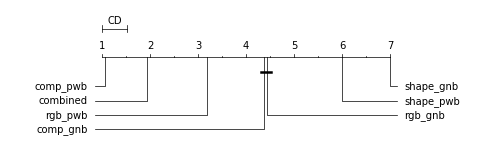

In [15]:
avg_rank = result.rank(axis=1, ascending=False)
avg_rank = avg_rank.mean()
cd = og.evaluation.compute_CD(avranks=avg_rank, n=len(result), alpha='0.05', test='nemenyi')
og.evaluation.graph_ranks(avranks=avg_rank, names=result.columns, cd=cd)
plt.show()